# Understanding the Kernel Trick in Support Vector Machines (SVM)

This notebook explores how Support Vector Machines (SVM) can learn non-linear decision boundaries using the **kernel trick**. 

We will:
- Build geometric intuition about SVM and margins.
- Explain the kernel trick mathematically.
- Use synthetic 2D datasets (`moons`, `circles`) to visualise linear vs non-linear decision boundaries.
- Apply SVM with linear and RBF kernels to a real dataset (Breast Cancer Wisconsin).
- Analyse performance and discuss when to use which kernel.


## 1. Learning Objectives

By the end of this notebook, the reader should be able to:

- Explain the difference between linear SVM and kernel SVM.
- Describe the kernel trick and why it is useful.
- Write down the mathematical form of common kernel functions.
- Visualise decision boundaries for linear and RBF SVM on non-linear datasets.
- Evaluate and compare SVM models on a real-world dataset using standard metrics.


## 2. Intuition: Why Do We Need Kernels?

A standard linear SVM tries to find a straight line (in 2D) or a hyperplane (in higher dimensions) that separates two classes with the largest possible margin. This works well if the data are linearly separable. However, many real problems are not linearly separable in the original feature space.

### Real-Life Analogy

Imagine you have two types of points on a 2D sheet arranged in a ring structure: inner points of one class and outer points of another class. No straight line can separate the classes in this 2D plane. If you could **lift the points into 3D** using a new feature (for example, radius from the origin), then a flat plane in 3D could cleanly separate them.

The kernel trick allows SVM to behave **as if** we had mapped the data into a higher-dimensional space, without explicitly computing that mapping. Instead, we replace inner products with a kernel function, which implicitly represents the inner product in some (possibly very high-dimensional) feature space.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

plt.style.use("seaborn-v0_8")

def plot_decision_boundary(model, X, y, title="", h=0.02):
    """
    Plot decision boundary for a 2D classifier.

    Parameters
    ----------
    model : fitted classifier with predict method
    X : array, shape (n_samples, 2)
        Input features (2D only).
    y : array, shape (n_samples,)
        Class labels.
    title : str
        Plot title.
    h : float
        Step size in the mesh grid.
    """
    x_min, x_max = X[:, 0].min() - 0.8, X[:, 0].max() + 0.8
    y_min, y_max = X[:, 1].min() - 0.8, X[:, 1].max() + 0.8
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.tight_layout()
    plt.show()


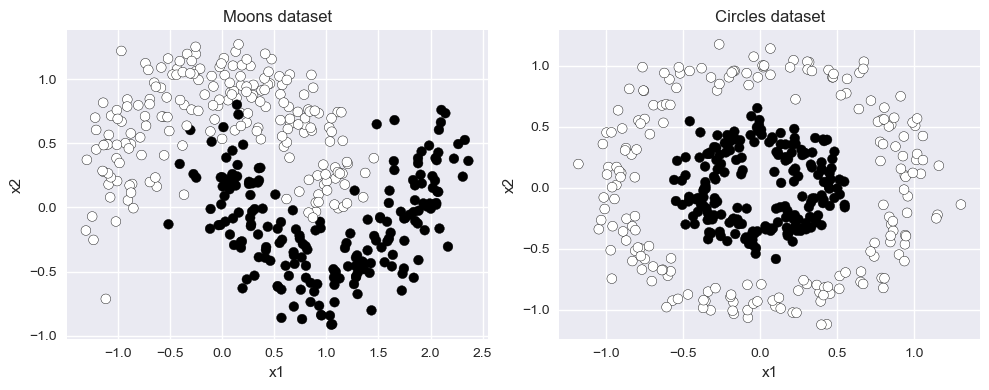

In [2]:
# Generate non-linearly separable datasets

X_moons, y_moons = make_moons(n_samples=400, noise=0.2, random_state=42)
X_circles, y_circles = make_circles(n_samples=400, noise=0.1, factor=0.4, random_state=42)

# Plot raw data
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, edgecolor="k")
axes[0].set_title("Moons dataset")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")

axes[1].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, edgecolor="k")
axes[1].set_title("Circles dataset")
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")

plt.tight_layout()
plt.show()


## 3. Linear SVM on Non-linearly Separable Data

We now fit a **linear SVM** on the moons and circles datasets. The linear SVM assumes that there exists a straight-line boundary in the original feature space. For these datasets, this assumption is violated by design.

The purpose of this step is to **show the limitation** of linear SVM and motivate the kernel trick.


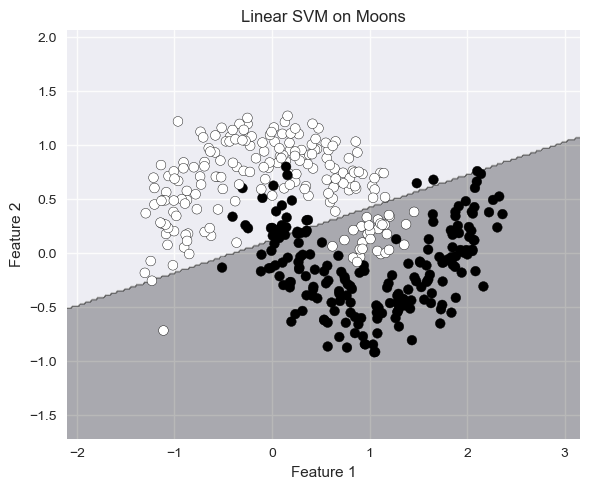

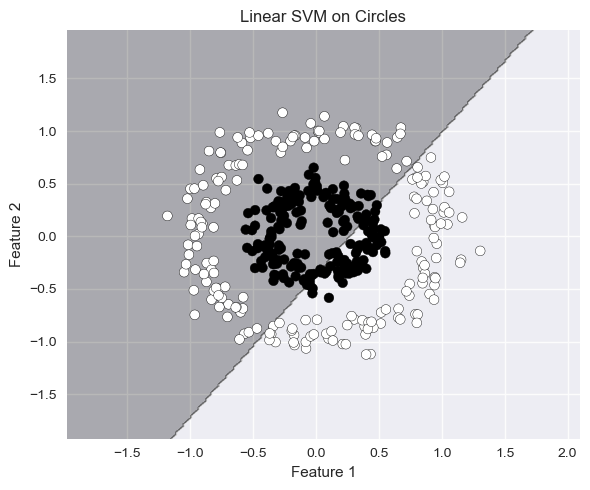

In [3]:
# Linear SVM (hinge loss, linear kernel) on moons
linear_svm_moons = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=1.0))
])
linear_svm_moons.fit(X_moons, y_moons)

plot_decision_boundary(linear_svm_moons, X_moons, y_moons,
                       title="Linear SVM on Moons")


# Linear SVM on circles
linear_svm_circles = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=1.0))
])
linear_svm_circles.fit(X_circles, y_circles)

plot_decision_boundary(linear_svm_circles, X_circles, y_circles,
                       title="Linear SVM on Circles")


### 3.1 Observations

The decision boundary of the linear SVM is essentially a straight line in the transformed space. On both the moons and circles datasets, this leads to **systematic misclassification**, especially in regions where classes intertwine. This behaviour illustrates that a linear decision boundary is not flexible enough to adapt to the inherent structure of the data.

To address this, we need a model that can create **curved** decision boundaries in the original feature space. SVM achieves this by using **kernel functions**.


## 4. The Kernel Trick

### 4.1 Feature Maps and Inner Products

In the standard SVM formulation, the decision function can be written as:

$$
f(x) = \text{sign} \left( \sum_{i=1}^n \alpha_i y_i \langle x_i, x \rangle + b \right)
$$

where \(x_i\) are support vectors, \(y_i\) are labels, and \(\alpha_i\) are learned coefficients.

If data are not linearly separable in the original space, one can map them to a higher-dimensional feature space via a function \(\phi(x)\), and use:

$$
f(x) = \text{sign} \left( \sum_{i=1}^n \alpha_i y_i \langle \phi(x_i), \phi(x) \rangle + b \right)
$$

However, explicitly computing \(\phi(x)\) can be very expensive or even infinite-dimensional.

### 4.2 Kernel Function

A **kernel function** is defined as:

$$
K(x_i, x_j) = \langle \phi(x_i), \phi(x_j) \rangle
$$

Instead of computing \(\phi(x)\) explicitly, we directly compute \(K(x_i, x)\). This is the **kernel trick**: SVM operates as if it were in the feature space, but only inner products are computed.

Common kernels:

- Linear kernel:
$$
  K(x, x') = x^\top x'
$$
- Polynomial kernel:
$$
  K(x, x') = (\gamma x^\top x' + r)^d
$$
- Radial Basis Function (RBF) kernel:
$$
  K(x, x') = \exp(-\gamma \|x - x'\|^2)
$$

The RBF kernel is especially powerful for capturing local, non-linear patterns.


## 5. Non-linear SVM with RBF Kernel

We now fit SVM models using the **RBF kernel** on the same datasets. This allows the SVM to create curved decision boundaries in the original 2D space by implicitly mapping data into a higher-dimensional feature space.

We keep the same data but only change the kernel from `"linear"` to `"rbf"`.


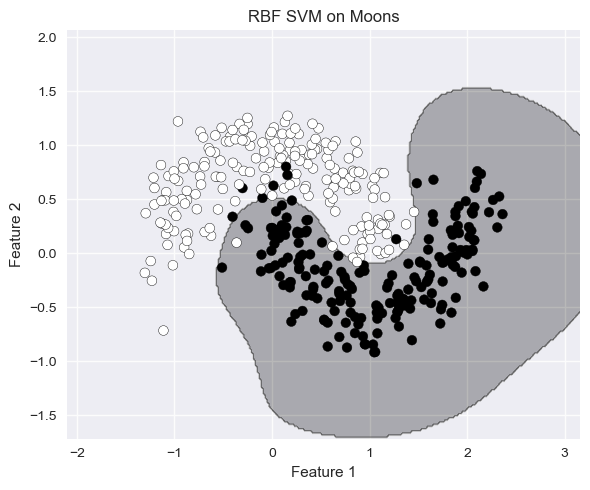

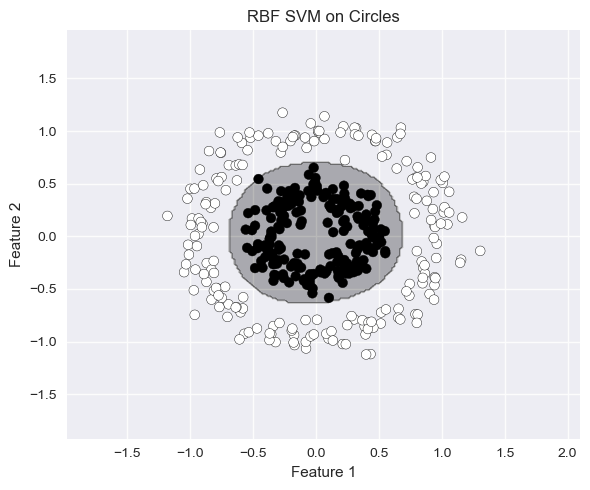

In [4]:
# RBF SVM on moons
rbf_svm_moons = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=1.0, gamma=1.0))
])
rbf_svm_moons.fit(X_moons, y_moons)

plot_decision_boundary(rbf_svm_moons, X_moons, y_moons,
                       title="RBF SVM on Moons")


# RBF SVM on circles
rbf_svm_circles = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=1.0, gamma=1.0))
])
rbf_svm_circles.fit(X_circles, y_circles)

plot_decision_boundary(rbf_svm_circles, X_circles, y_circles,
                       title="RBF SVM on Circles")


### 5.1 Effect of C and Gamma

For the RBF kernel, two important hyperparameters are:

- **C**: controls the trade-off between margin size and misclassification. A large C tries to classify all training points correctly, which can overfit.
- **Gamma**: controls how far the influence of a single training example reaches. A small gamma means a wider area of influence; a large gamma makes the model focus more locally.

We briefly visualise how changing gamma affects the decision boundary on the moons dataset.


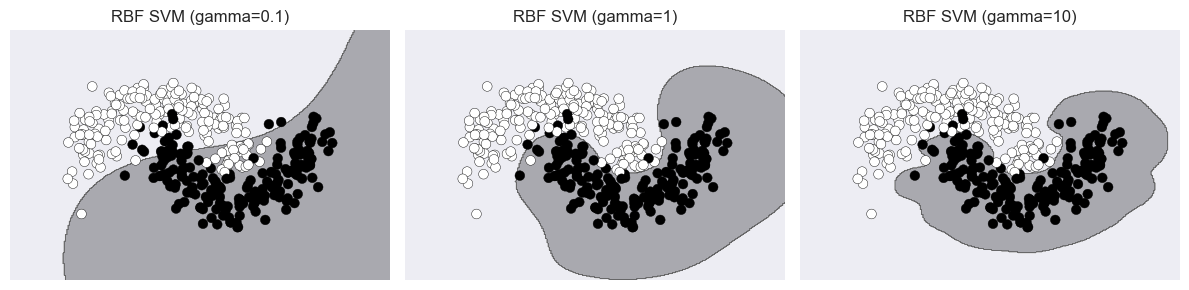

In [5]:
gammas = [0.1, 1, 10]
plt.figure(figsize=(12, 3))

for i, g in enumerate(gammas, 1):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", C=1.0, gamma=g))
    ])
    model.fit(X_moons, y_moons)

    x_min, x_max = X_moons[:, 0].min() - 0.8, X_moons[:, 0].max() + 0.8
    y_min, y_max = X_moons[:, 1].min() - 0.8, X_moons[:, 1].max() + 0.8
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax = plt.subplot(1, 3, i)
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, edgecolor="k")
    ax.set_title(f"RBF SVM (gamma={g})")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


## 6. Application to a Real Dataset: Breast Cancer

To move beyond synthetic examples, we now apply SVMs to the **Breast Cancer Wisconsin** dataset, which is available directly from scikit-learn. This dataset contains features computed from fine needle aspirate (FNA) of breast masses and labels indicating whether the tumour is malignant or benign.

We will compare two models:

- SVM with a linear kernel
- SVM with an RBF kernel

and evaluate them in terms of accuracy, precision, recall and F1-score.


In [6]:
data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((455, 30), (114, 30))

In [7]:
# Linear SVM model
linear_svm_bc = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=1.0))
])

# RBF SVM model
rbf_svm_bc = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

linear_svm_bc.fit(X_train, y_train)
rbf_svm_bc.fit(X_train, y_train)

y_pred_linear = linear_svm_bc.predict(X_test)
y_pred_rbf = rbf_svm_bc.predict(X_test)


Linear SVM (Breast Cancer) Accuracy: 0.974

Classification report for Linear SVM (Breast Cancer):

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



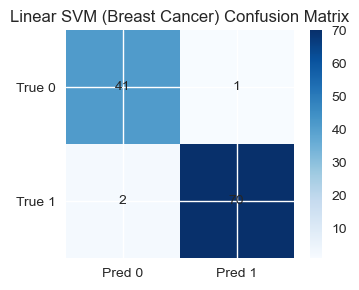

RBF SVM (Breast Cancer) Accuracy: 0.982

Classification report for RBF SVM (Breast Cancer):

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



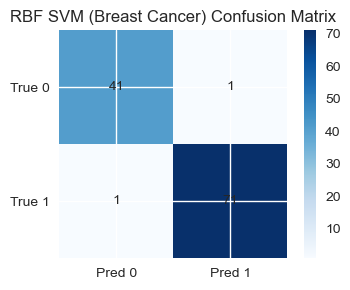

In [8]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    print(f"{model_name} Accuracy: {acc:.3f}")
    print(f"\nClassification report for {model_name}:\n")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.colorbar()
    plt.xticks([0, 1], ["Pred 0", "Pred 1"])
    plt.yticks([0, 1], ["True 0", "True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

    return acc

acc_linear = evaluate_model(y_test, y_pred_linear, "Linear SVM (Breast Cancer)")
acc_rbf = evaluate_model(y_test, y_pred_rbf, "RBF SVM (Breast Cancer)")


## 7. Discussion of Results

On the synthetic datasets, the linear SVM struggled to separate classes that are intertwined in a non-linear way. The RBF SVM, by contrast, produced smooth, curved decision boundaries that closely followed the underlying structure of the data. This illustrates the benefit of the kernel trick: it enables SVM to model non-linear patterns without ever explicitly computing high-dimensional feature mappings.

On the Breast Cancer dataset, both linear and RBF SVM achieved high classification performance, reflecting that the dataset is relatively well-behaved and becomes more separable after standardisation. In many tabular datasets with a large number of informative features, a linear SVM can already perform strongly, while the RBF kernel may deliver marginal gains at the cost of additional computational complexity.

The choice between linear and non-linear kernels therefore depends on the underlying structure of the data, interpretability requirements and computational budget. The kernel trick provides the flexibility to adapt SVM to both simple linear problems and complex non-linear ones using the same underlying optimisation framework.


## 8. Conclusion

This notebook has demonstrated how the kernel trick extends SVM from a linear classifier to a powerful non-linear model. By replacing inner products with kernel functions, SVM can operate in high-dimensional feature spaces without explicitly computing the feature map. Theoretical insight, mathematical formulation and visual experiments on synthetic datasets highlight the role of kernels in shaping decision boundaries. Evaluation on a real-world breast cancer dataset shows that both linear and RBF kernels can be effective, but kernel choice should be guided by data characteristics and modelling goals.
